<font face = "Verdana" size ="5">This notebook tracks and predict the spread of the novel coronavirus, also known as SARS-CoV-2. 
    <br><br>Data: <a href='https://github.com/CSSEGISandData/COVID-19'>https://github.com/CSSEGISandData/COVID-19</a>
     </font>
   <br>

In [129]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [130]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-09-2020.csv')

In [131]:
latest_data.head()

FIPS     Admin2  Province_State Country_Region          Last_Update  \
0  45001.0  Abbeville  South Carolina             US  2020-04-09 23:02:37   
1  22001.0     Acadia       Louisiana             US  2020-04-09 23:02:37   
2  51001.0   Accomack        Virginia             US  2020-04-09 23:02:37   
3  16001.0        Ada           Idaho             US  2020-04-09 23:02:37   
4  19001.0      Adair            Iowa             US  2020-04-09 23:02:37   

         Lat       Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334  -82.461707          7       0          0       0   
1  30.295065  -92.414197         89       3          0       0   
2  37.767072  -75.632346         11       0          0       0   
3  43.452658 -116.241552        447       5          0       0   
4  41.330756  -94.471059          1       0          0       0   

                    Combined_Key  
0  Abbeville, South Carolina, US  
1          Acadia, Louisiana, US  
2         Accomack, Virginia, US  
3                 Ada, Idaho, US  
4                Adair, Iowa, US

In [132]:
confirmed_df.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/31/20  4/1/20  4/2/20  4/3/20  4/4/20  \
0        0        0        0  ...      174     237     273     281     299   
1        0        0        0  ...      243     259     277     304     333   
2        0        0        0  ...      716     847     986    1171    1251   
3        0        0        0  ...      376     390     428     439     466   
4        0        0        0  ...        7       8       8       8      10   

   4/5/20  4/6/20  4/7/20  4/8/20  4/9/20  
0     349     367     423     444     484  
1     361     377     383     400     409  
2    1320    1423    1468    1572    1666  
3     501     525     545     564     583  
4      14      16      17      19      19  

[5 rows x 83 columns]

In [133]:
cols = confirmed_df.keys()


Get all the dates for the outbreak

In [134]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [135]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 

china_deaths = [] 
italy_deaths = []
us_deaths = [] 
spain_deaths = [] 
france_deaths = [] 

china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
spain_recoveries = [] 
france_recoveries = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][i].sum())
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    france_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='France'][i].sum())

Getting daily increases

In [136]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
spain_daily_death = daily_increase(spain_deaths)
france_daily_death = daily_increase(france_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
spain_daily_recovery = daily_increase(spain_recoveries)
france_daily_recovery = daily_increase(france_recoveries)

In [137]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [138]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [139]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [140]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.05, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [141]:
# use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6, 7]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [142]:
# svm_search.best_params_

In [143]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 89575.76732501388
MSE: 8058318625.954113


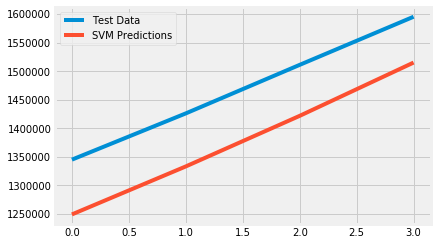

In [144]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [145]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [146]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 131982.9534719973
MSE: 19781891462.86329


In [147]:
print(linear_model.coef_)

[[ 1.18212915e+04 -6.61737098e+03  8.96173583e+02 -2.89178132e+01
   3.03748183e-01 -2.32928208e-04]]


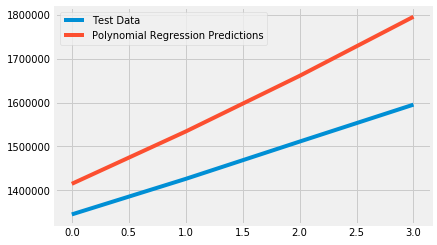

In [148]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [149]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e

In [150]:
bayesian_search.best_params_

{'tol': 0.0001,
 'lambda_2': 1e-07,
 'lambda_1': 1e-07,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [151]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 20984.355145327107
MSE: 703383063.8111209


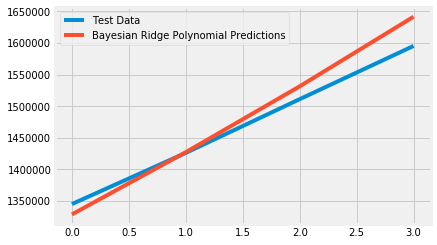

In [152]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

 Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

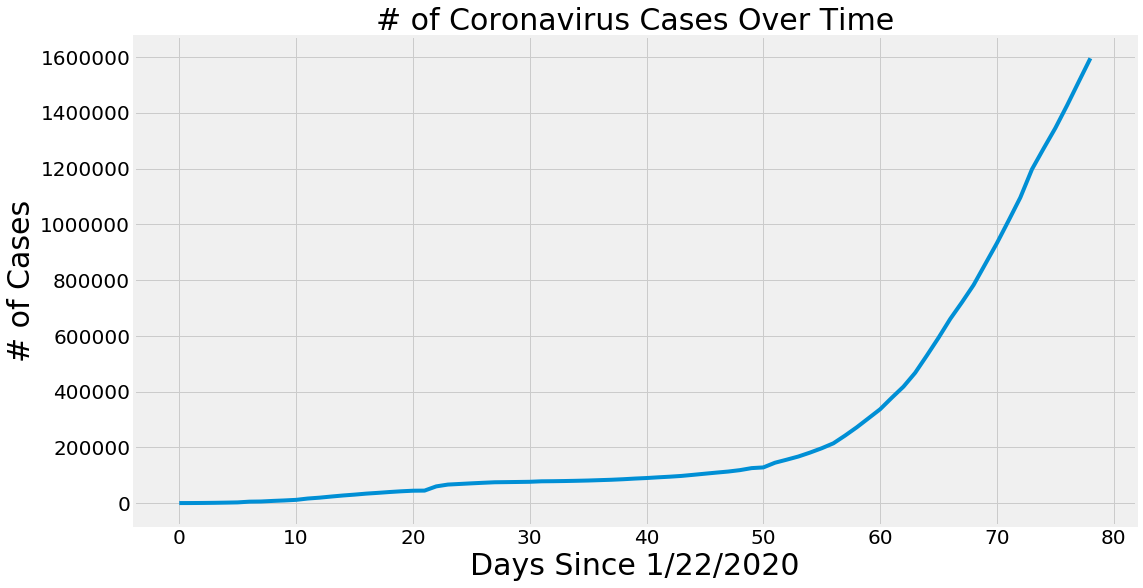

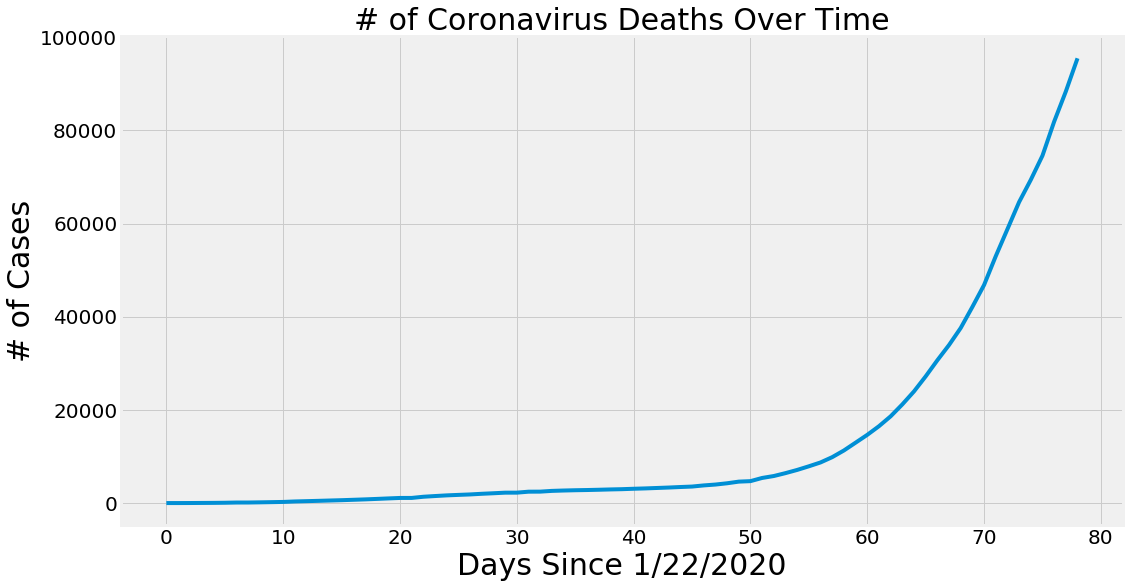

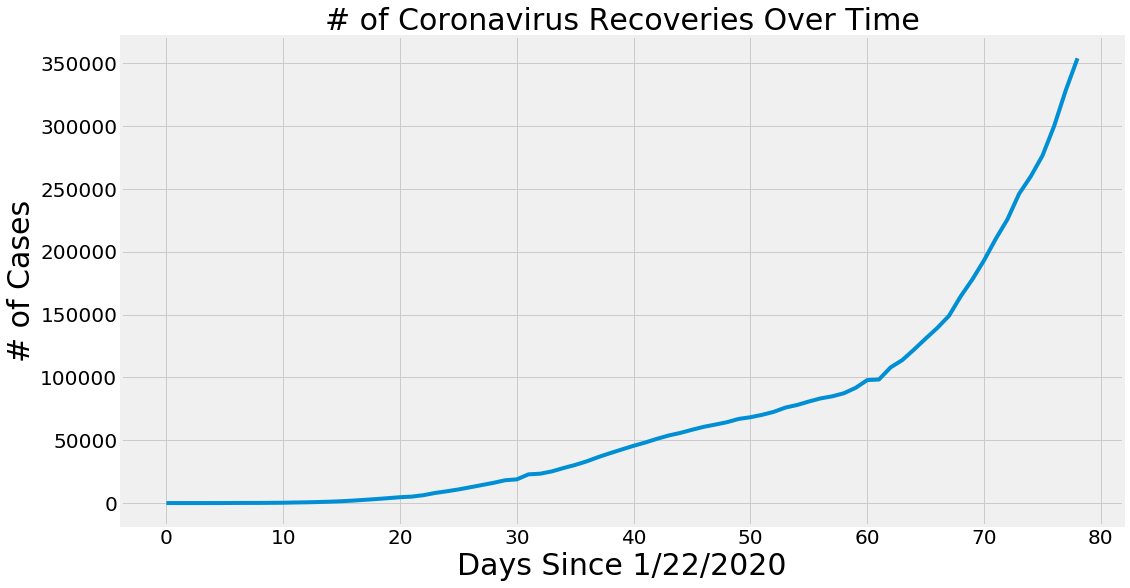

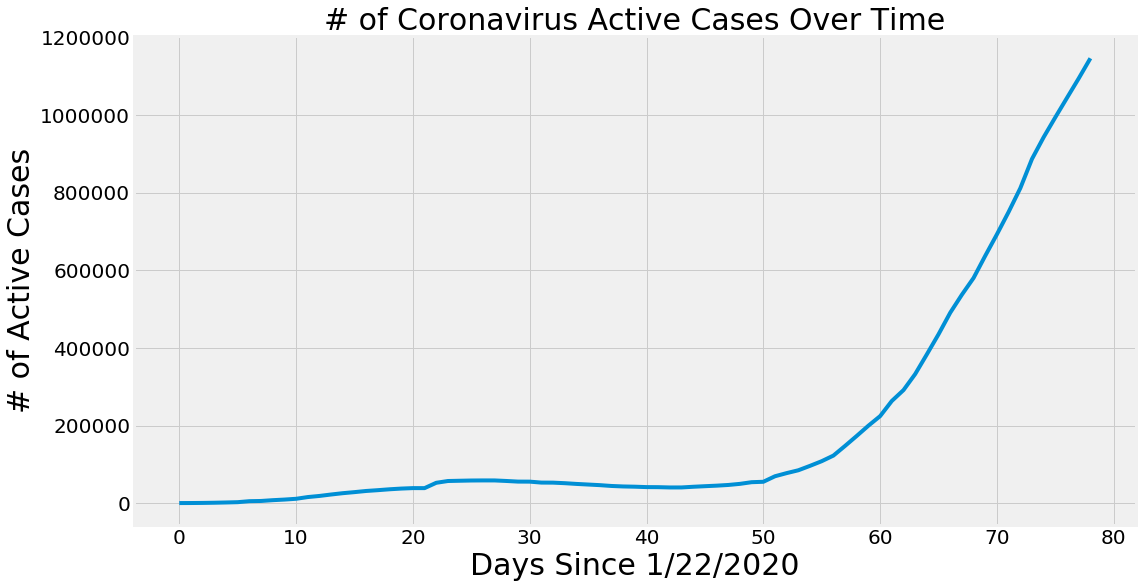

In [153]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

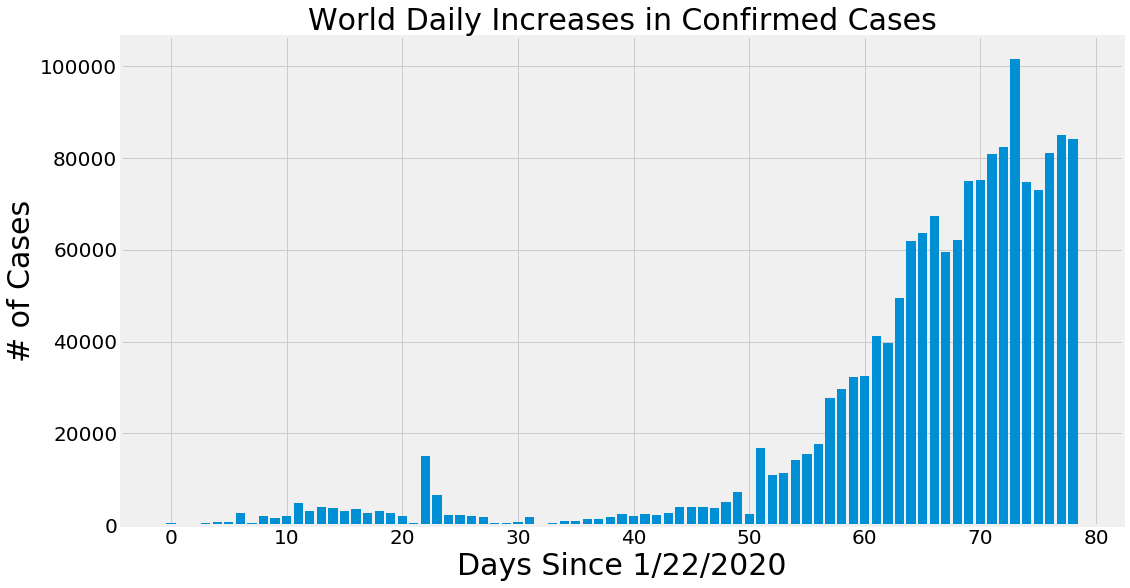

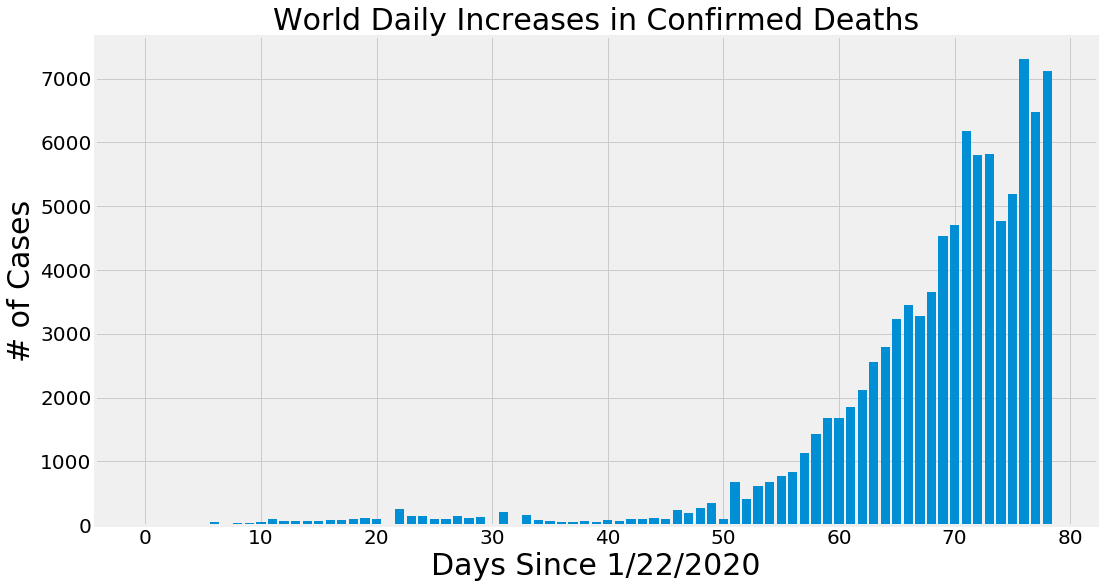

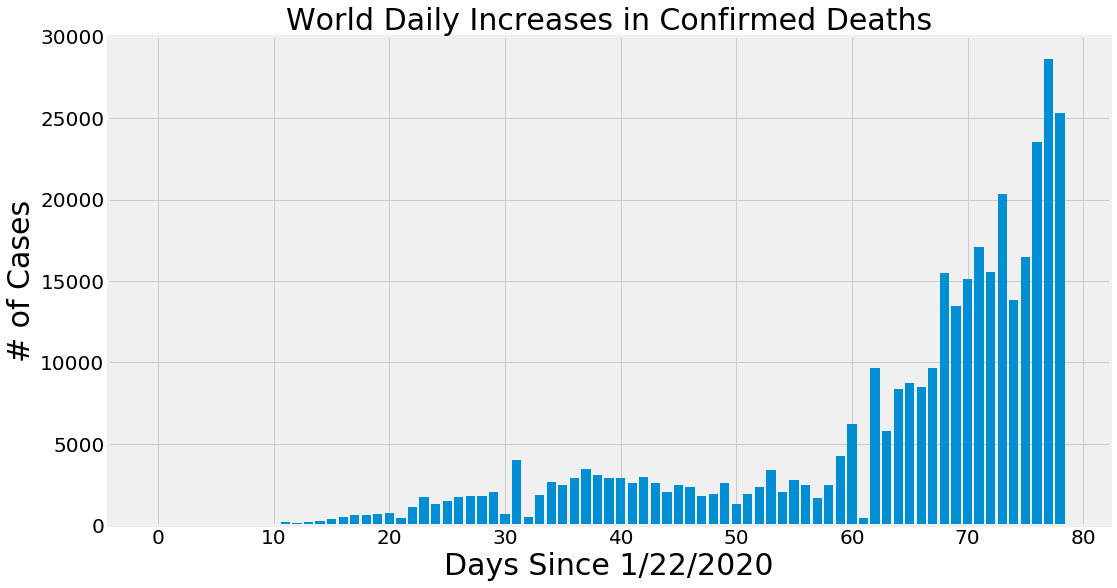

In [154]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

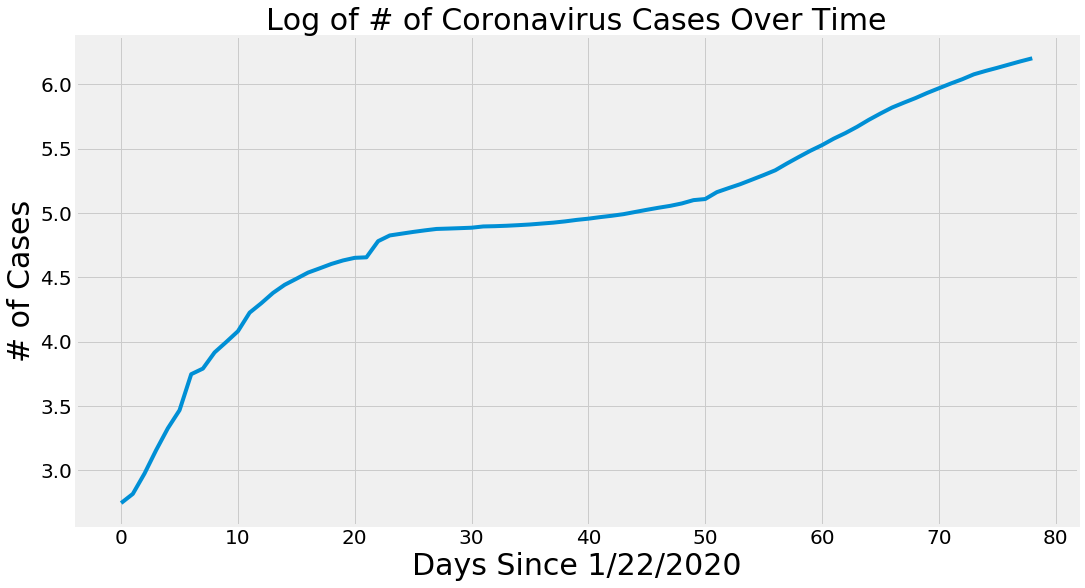

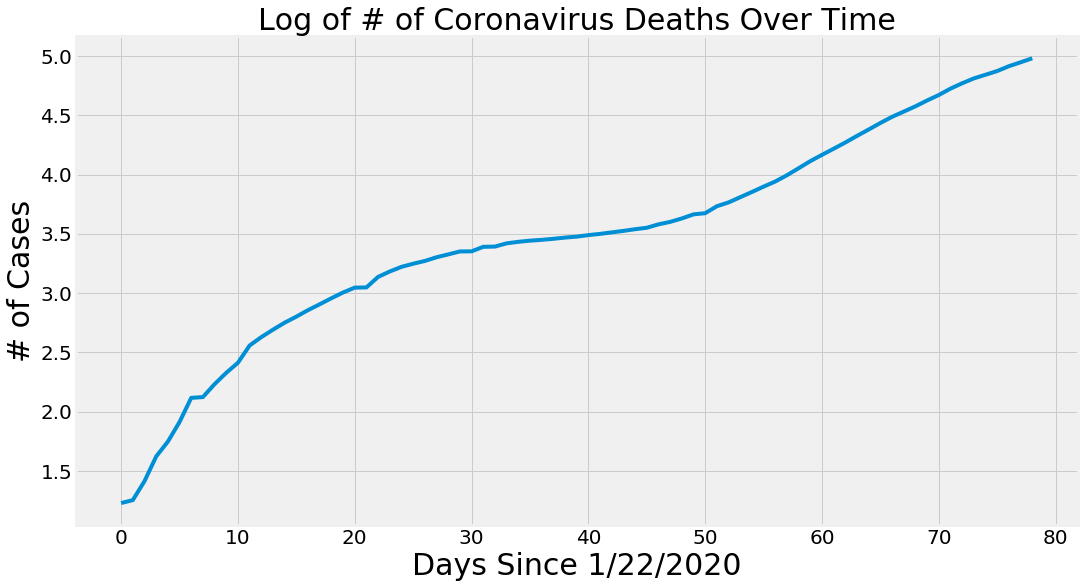

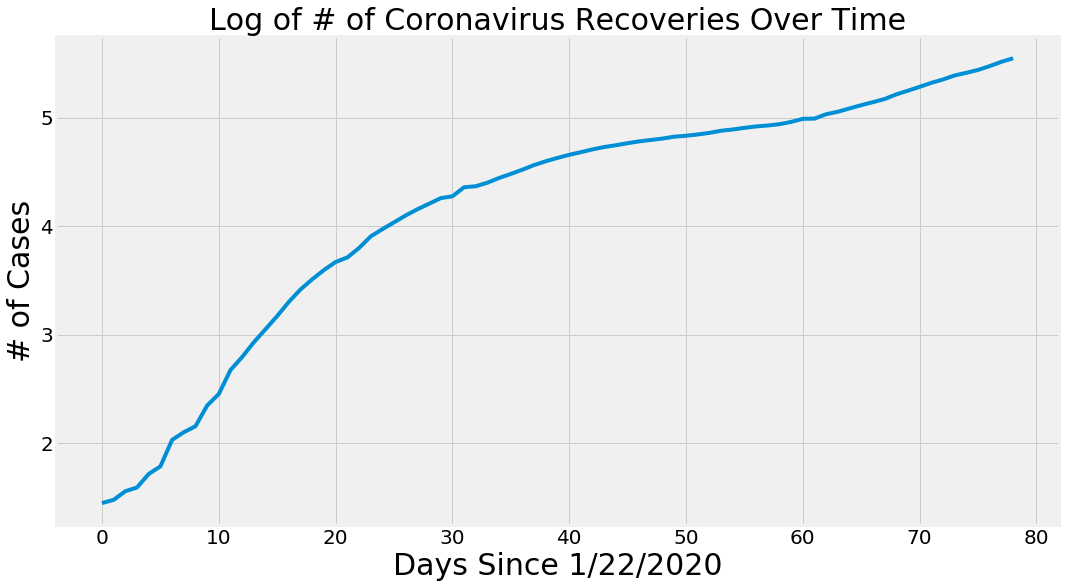

In [155]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(total_recovered))
plt.title('Log of # of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

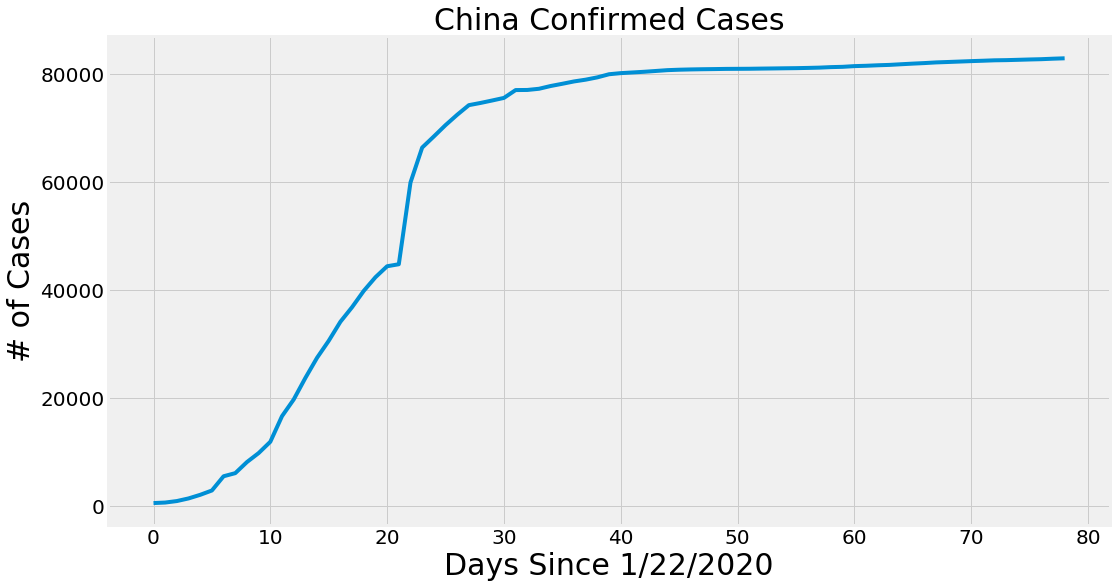

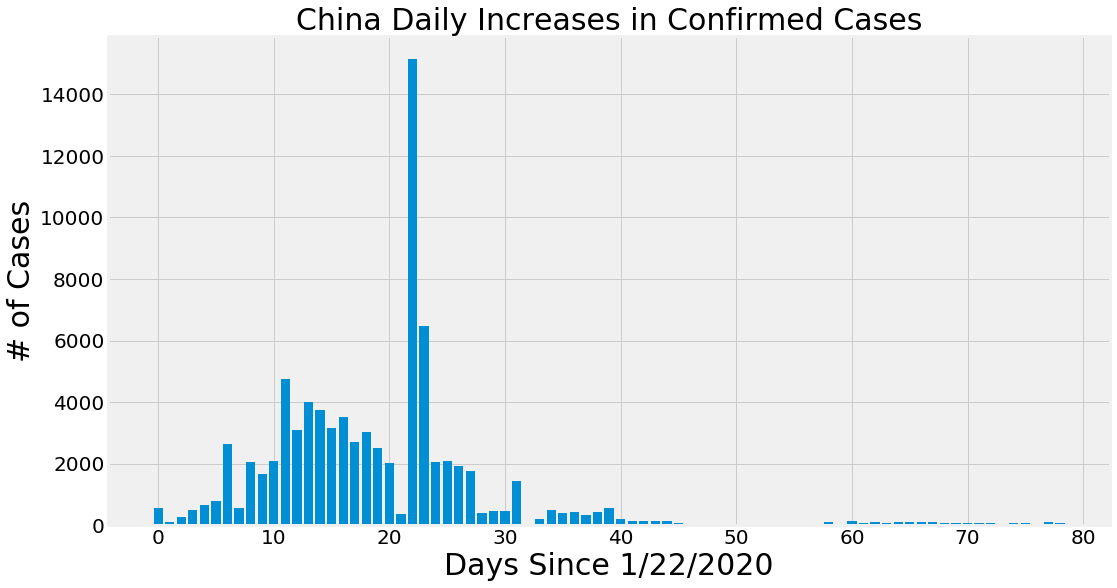

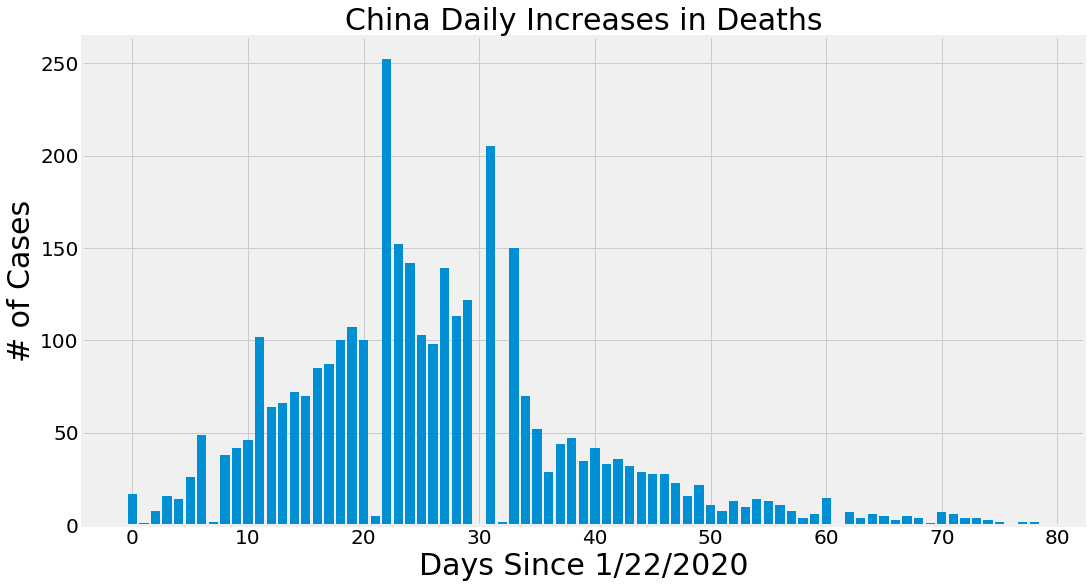

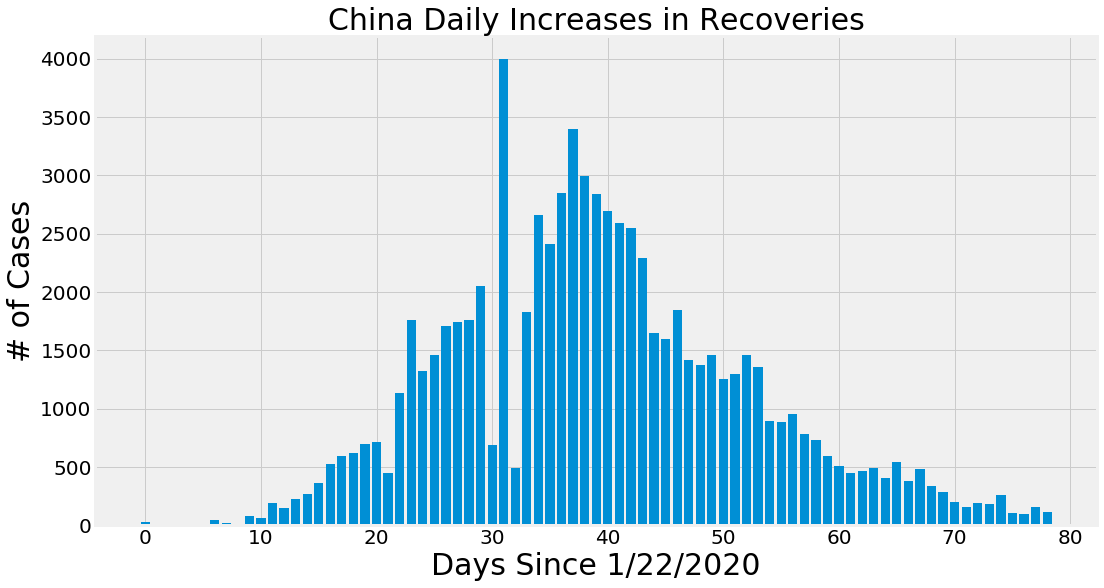

In [156]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.title('China Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_increase)
plt.title('China Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_death)
plt.title('China Daily Increases in Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_recovery)
plt.title('China Daily Increases in Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

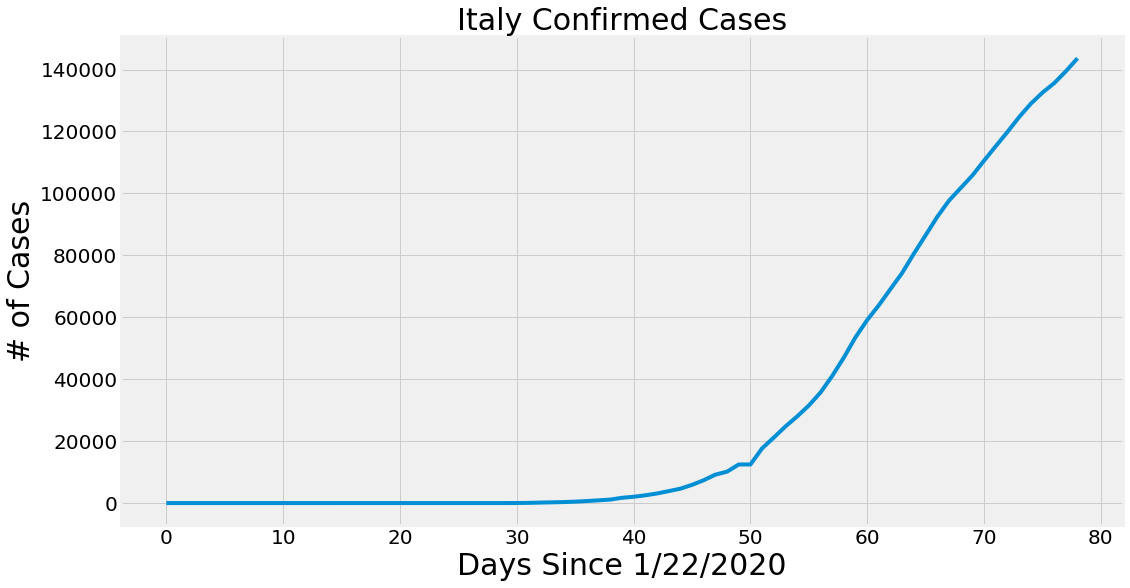

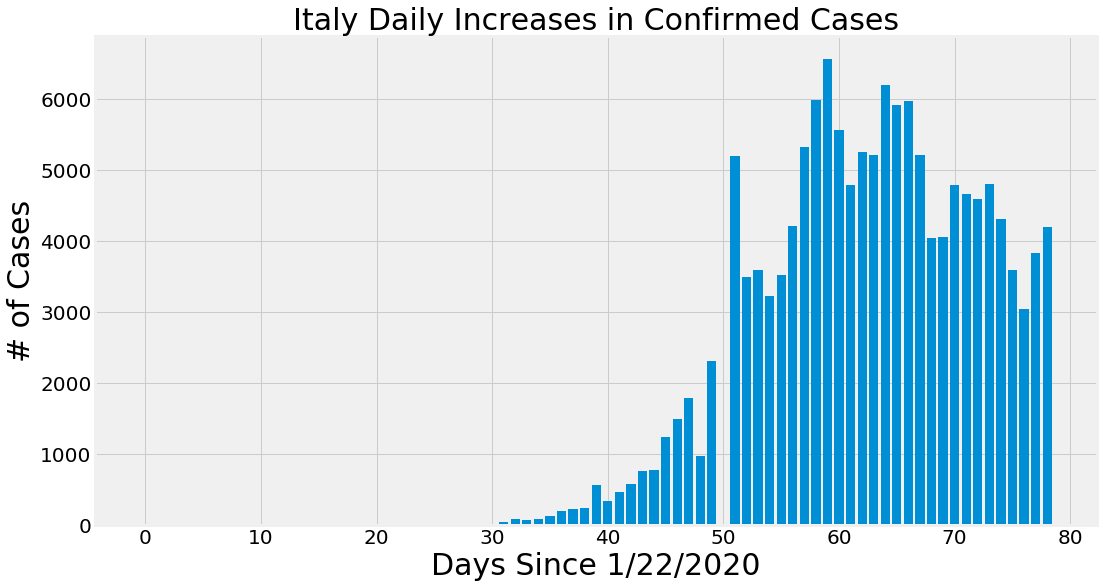

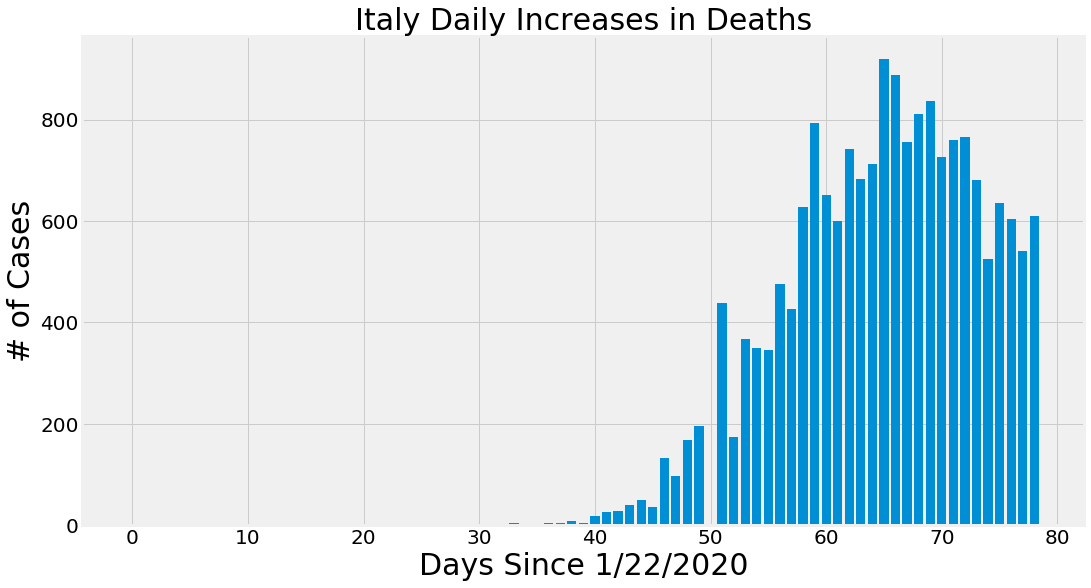

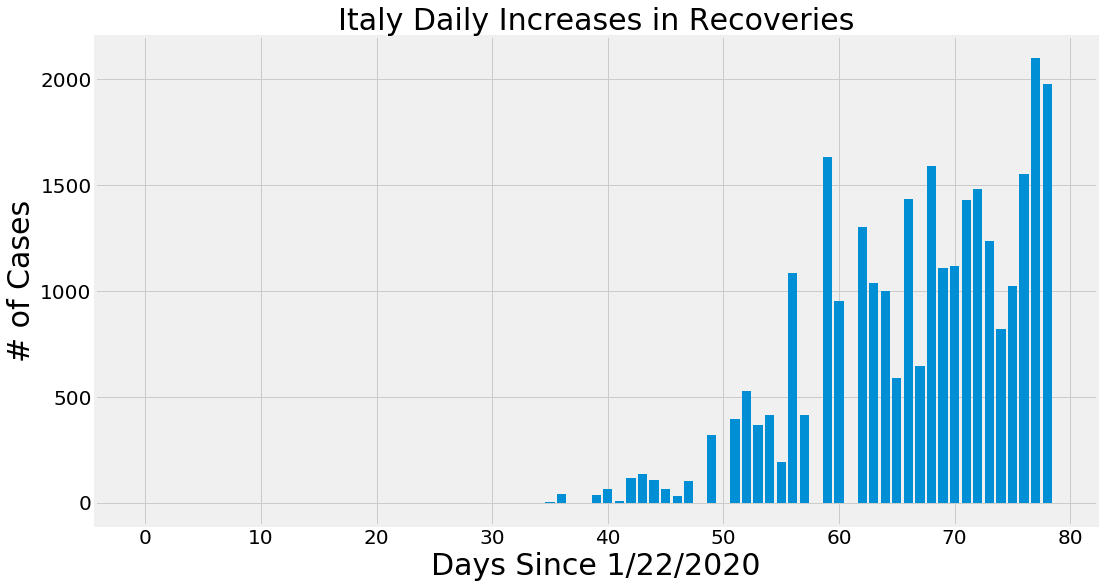

In [157]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, italy_cases)
plt.title('Italy Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_increase)
plt.title('Italy Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_death)
plt.title('Italy Daily Increases in Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_recovery)
plt.title('Italy Daily Increases in Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

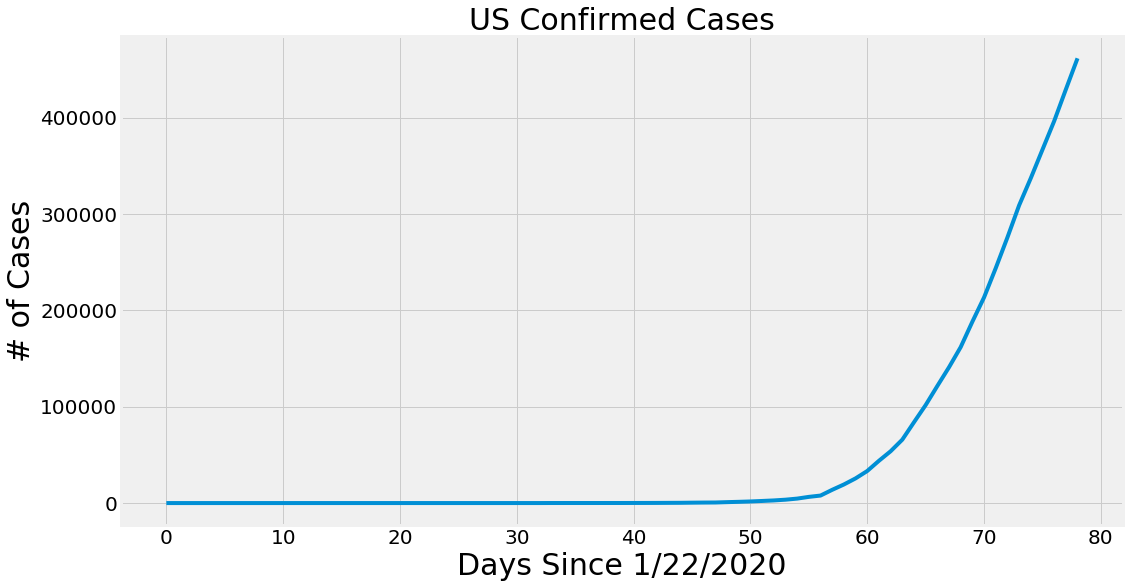

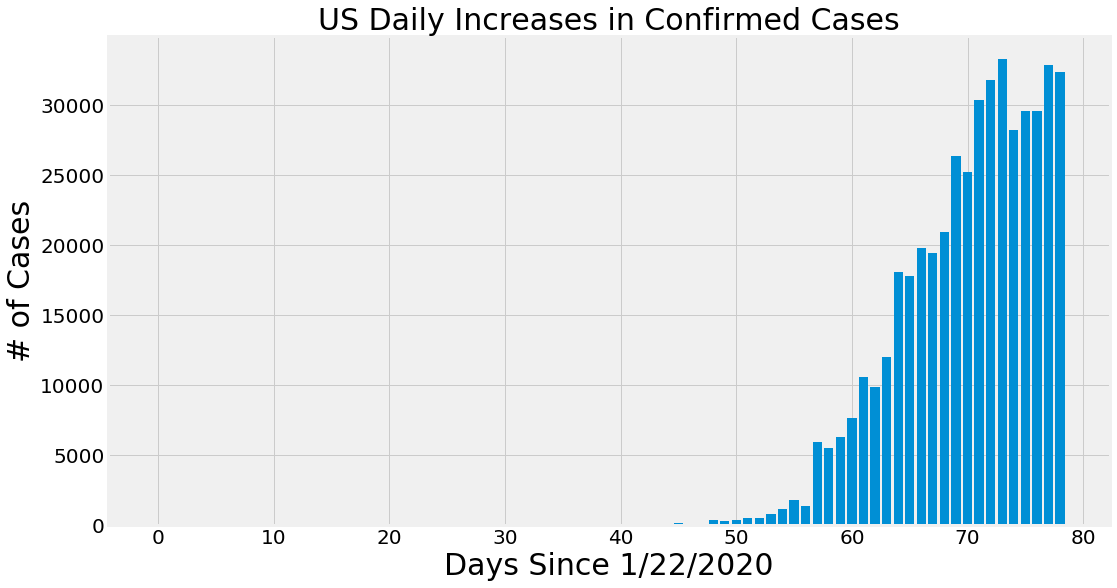

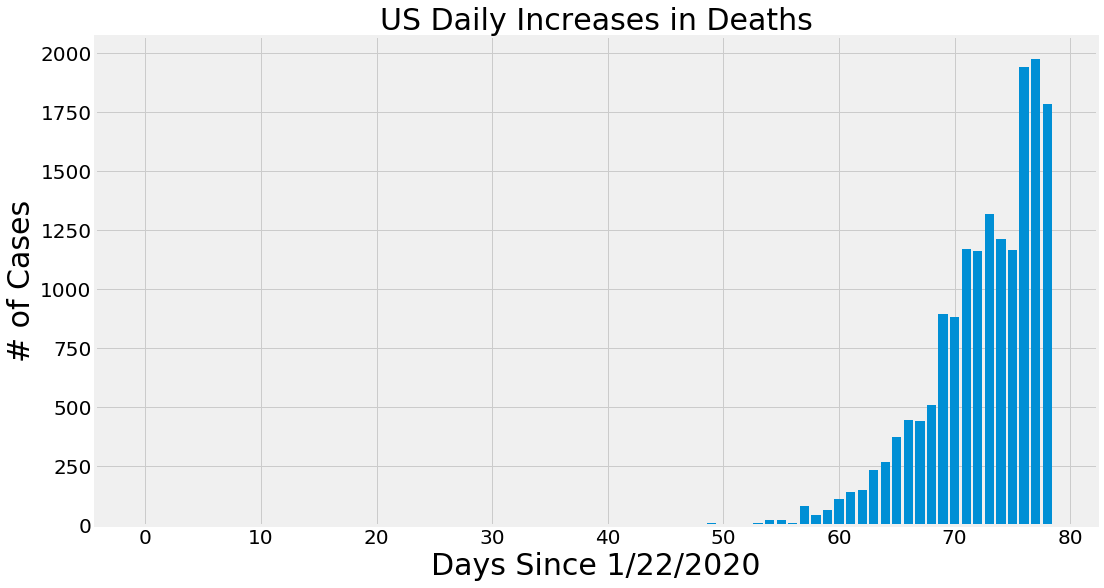

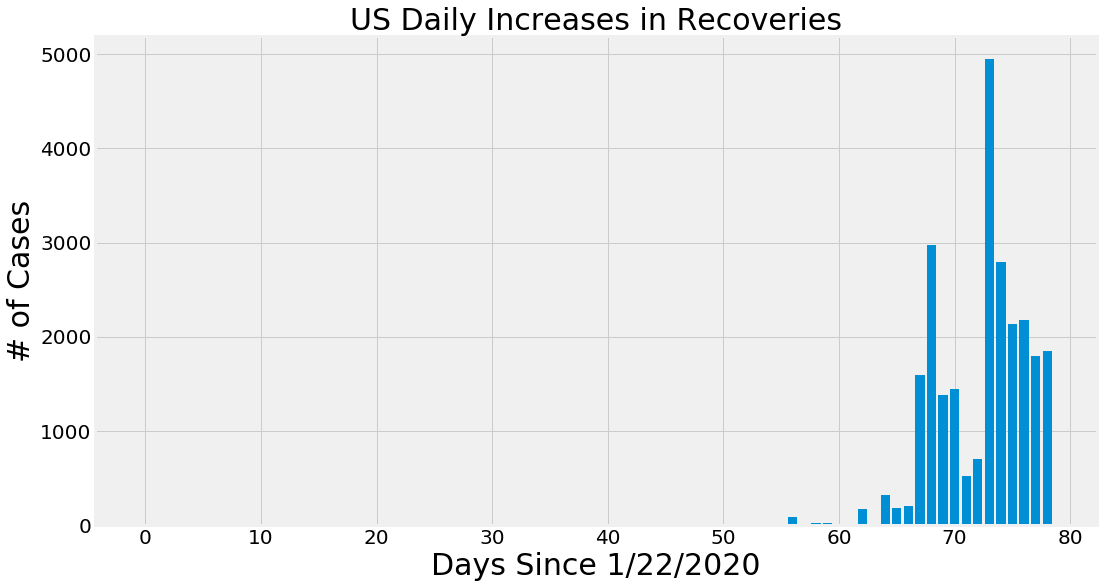

In [158]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, us_cases)
plt.title('US Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_increase)
plt.title('US Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_death)
plt.title('US Daily Increases in Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_recovery)
plt.title('US Daily Increases in Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

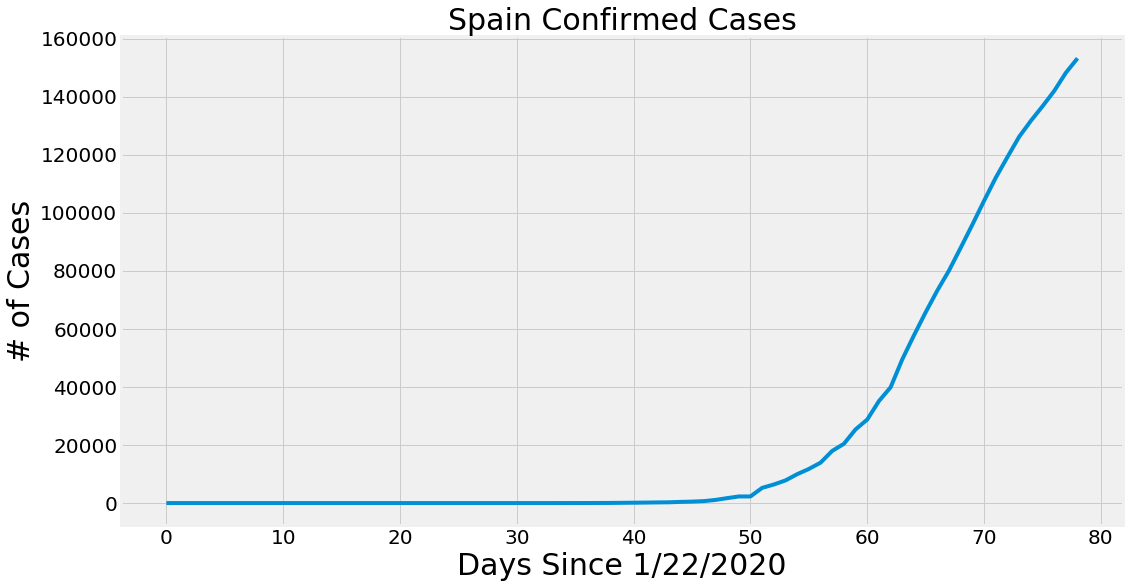

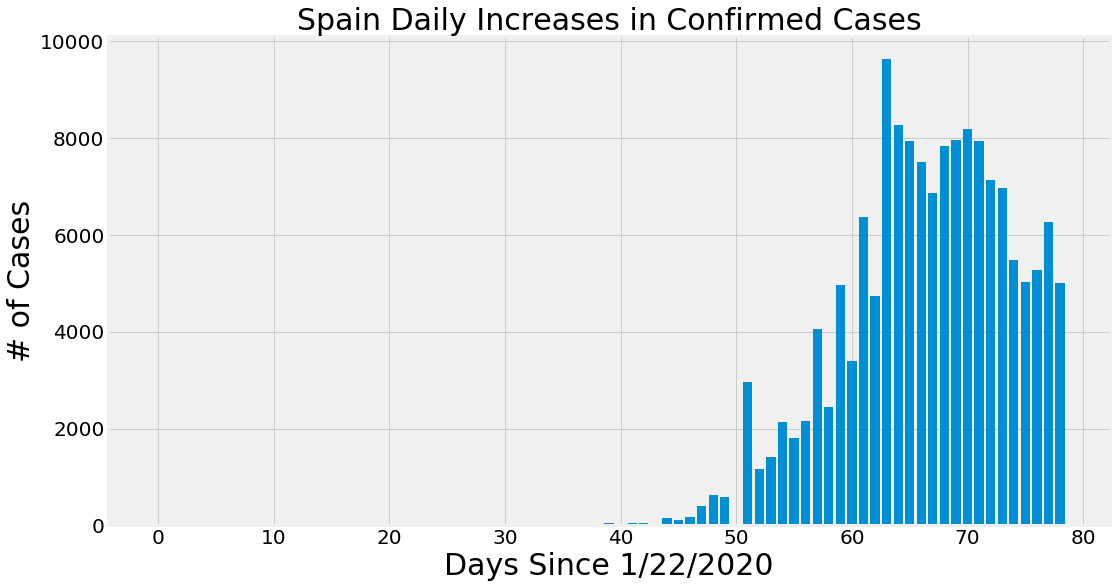

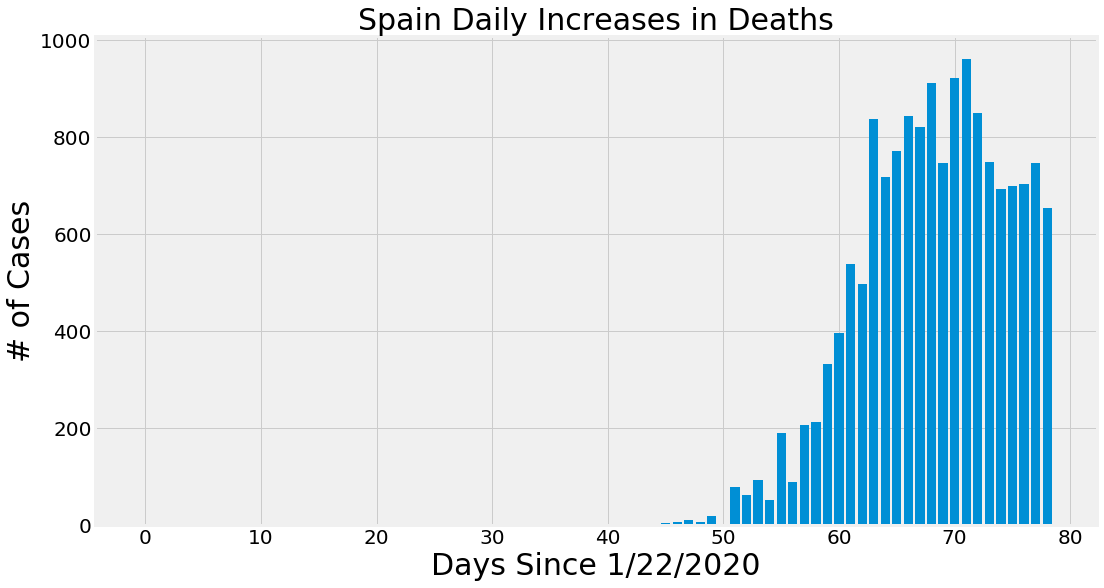

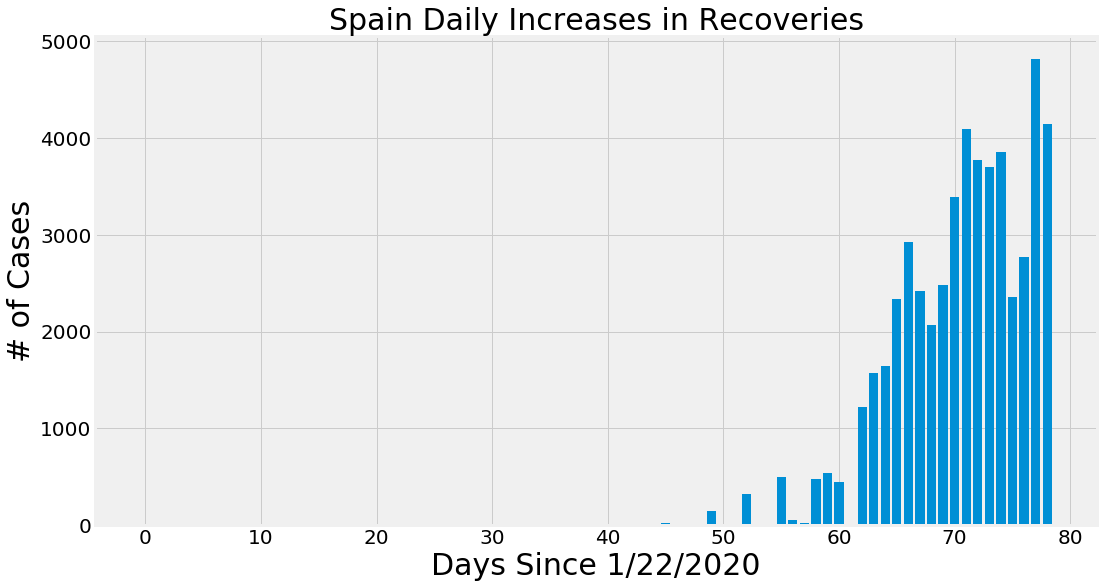

In [159]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, spain_cases)
plt.title('Spain Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_increase)
plt.title('Spain Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_death)
plt.title('Spain Daily Increases in Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_recovery)
plt.title('Spain Daily Increases in Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

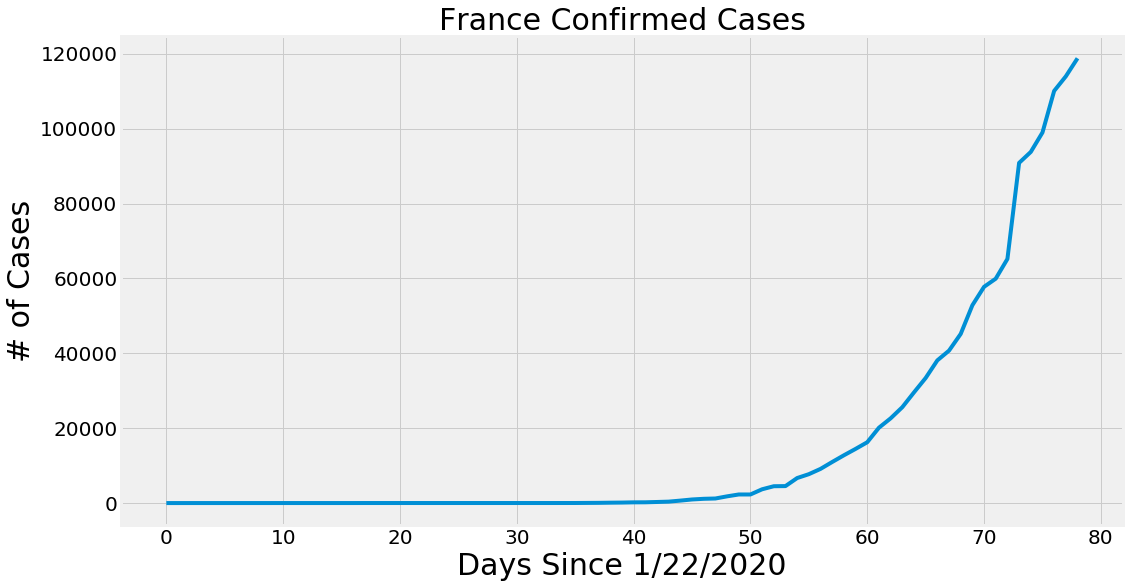

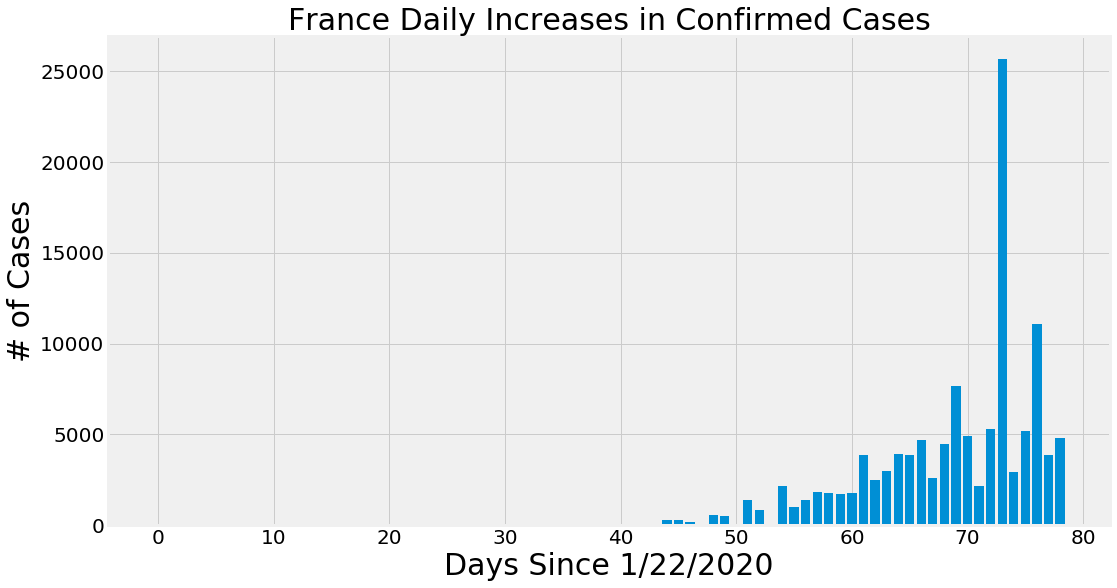

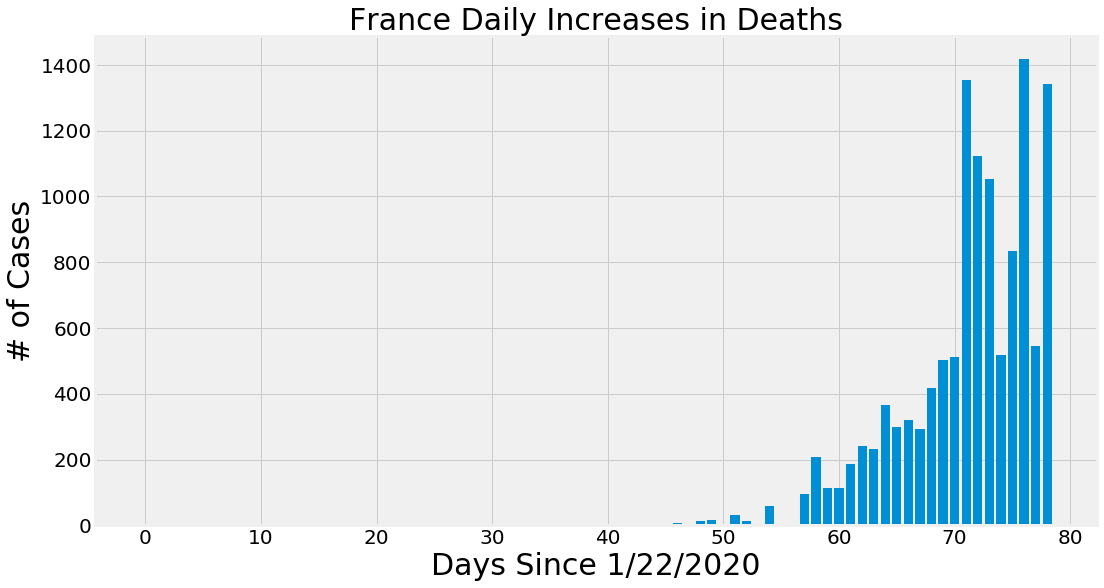

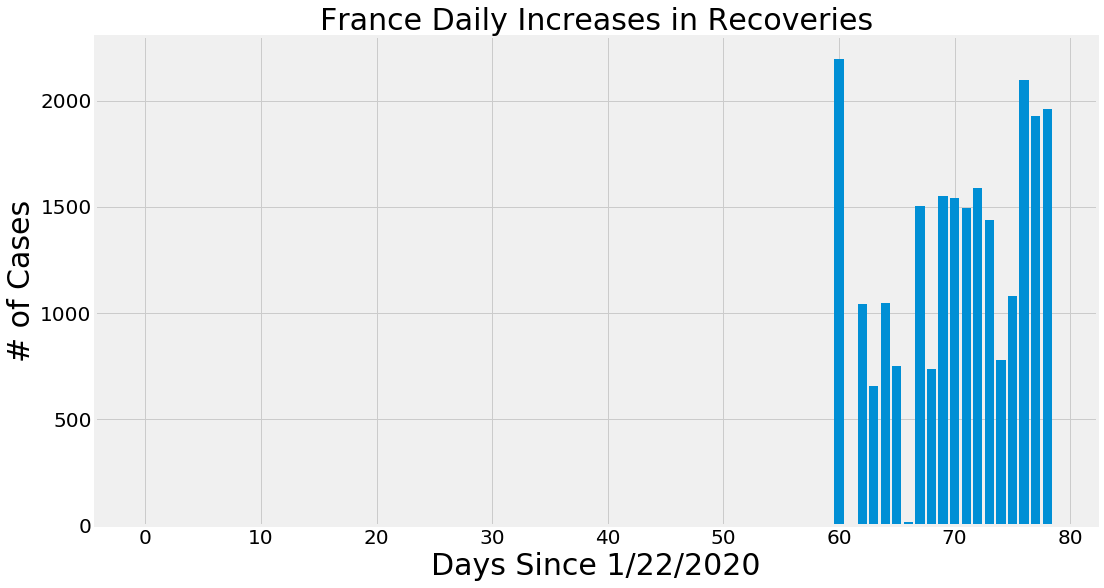

In [160]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, france_cases)
plt.title('France Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, france_daily_increase)
plt.title('France Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, france_daily_death)
plt.title('France Daily Increases in Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, france_daily_recovery)
plt.title('France Daily Increases in Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

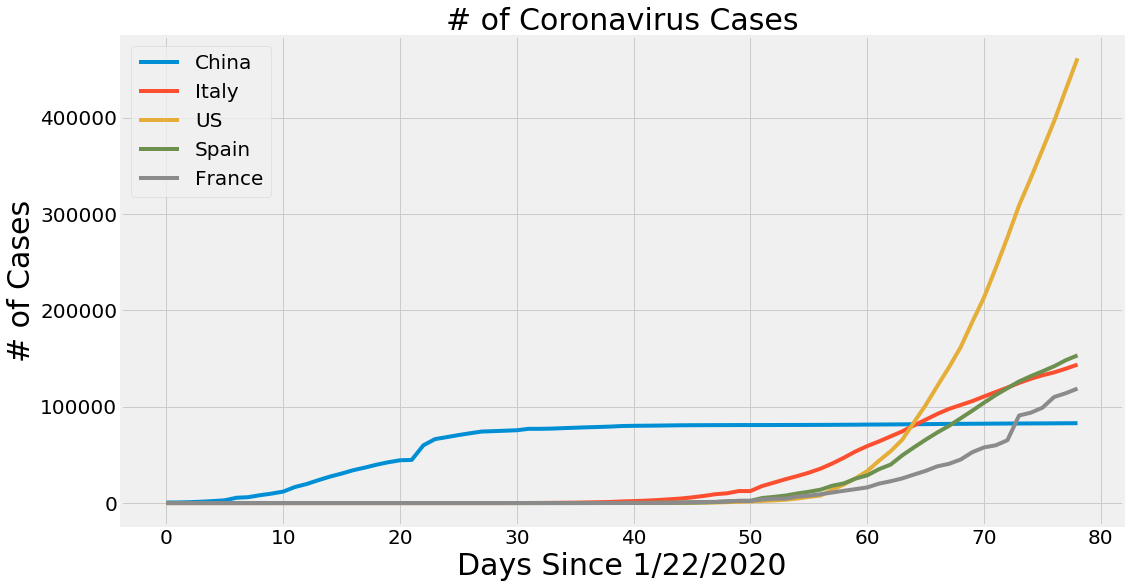

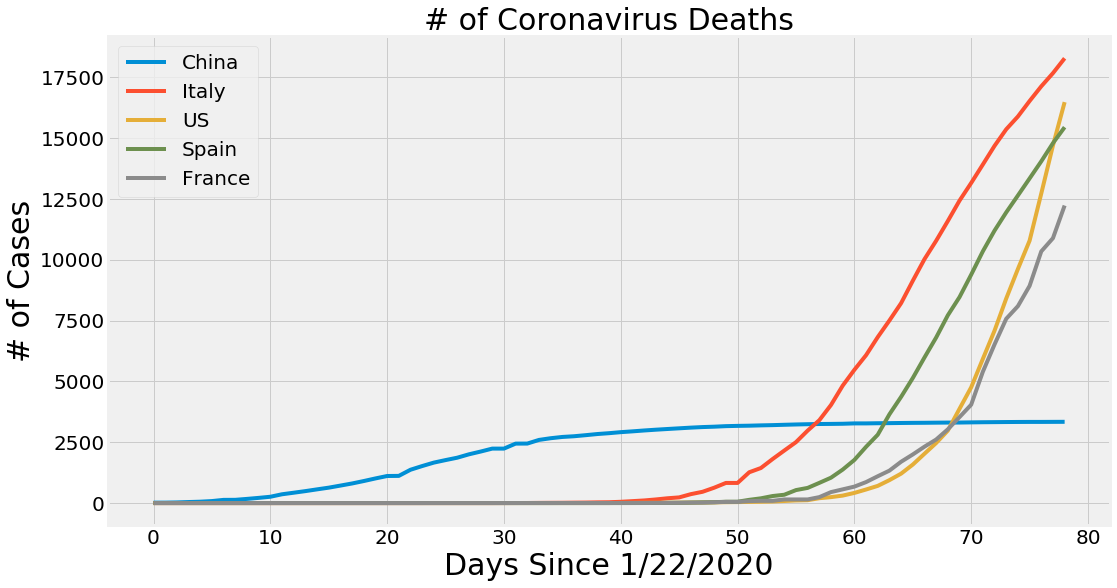

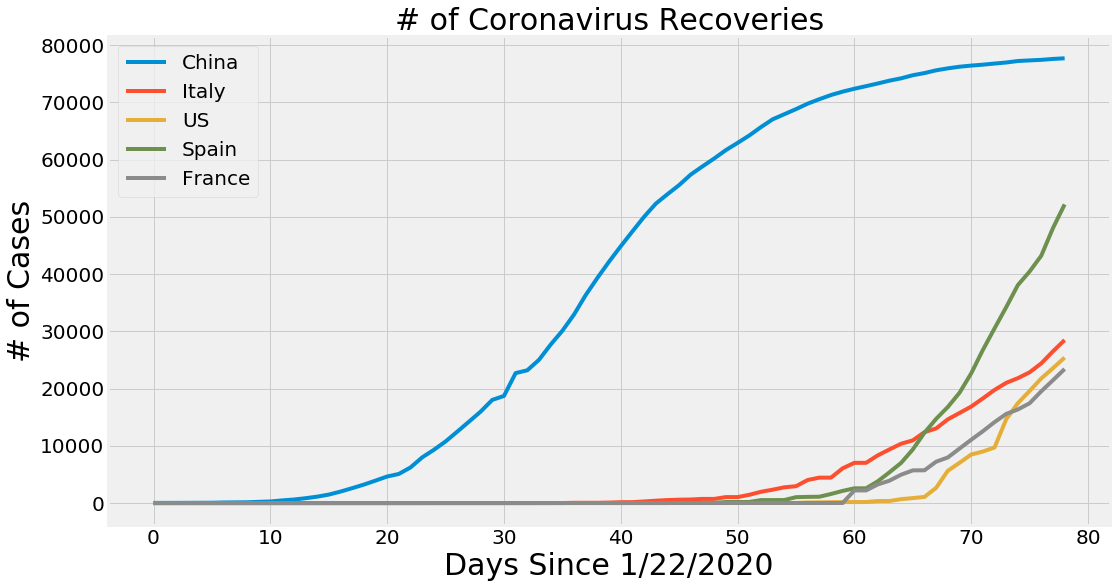

In [161]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, france_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, spain_deaths)
plt.plot(adjusted_dates, france_deaths)
plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, spain_recoveries)
plt.plot(adjusted_dates, france_recoveries)
plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

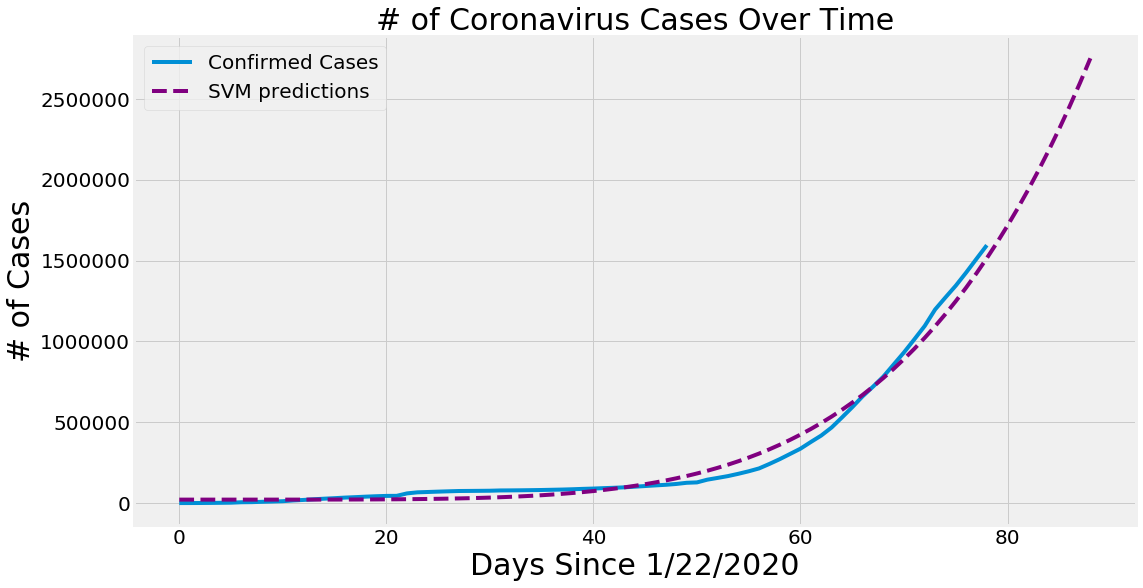

In [162]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

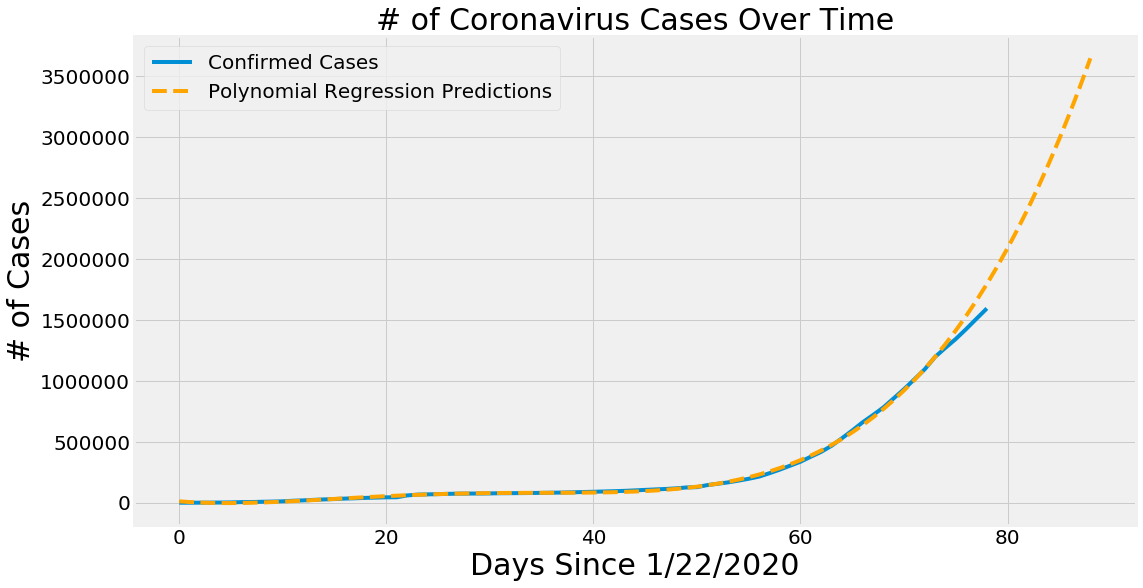

In [163]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

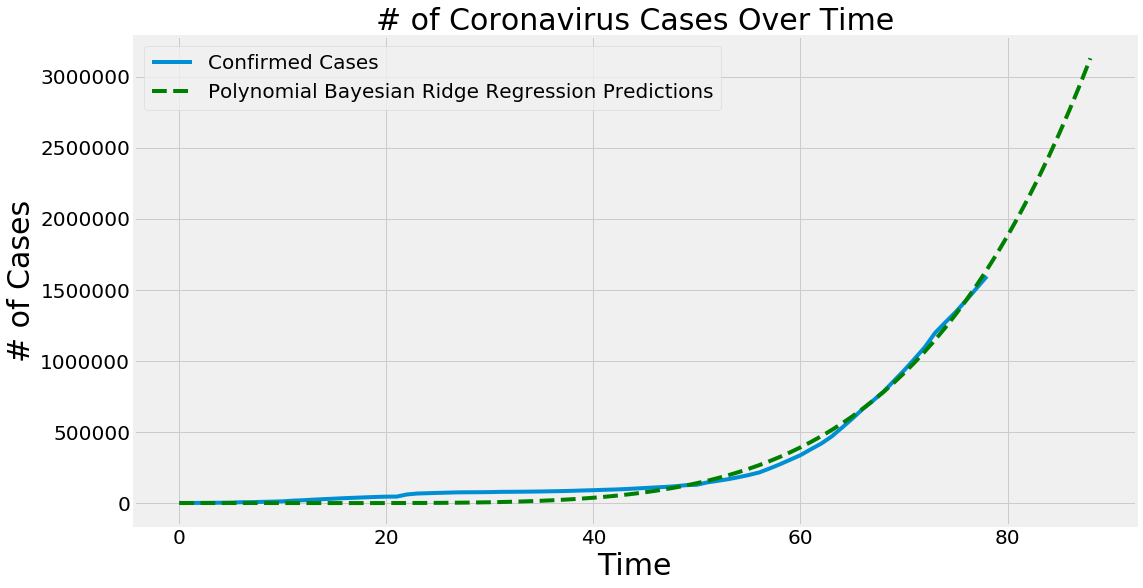

In [164]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [165]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

Date  SVM Predicted # of Confirmed Cases Worldwide
0  04/10/2020                                     1613314.0
1  04/11/2020                                     1716622.0
2  04/12/2020                                     1825227.0
3  04/13/2020                                     1939329.0
4  04/14/2020                                     2059134.0
5  04/15/2020                                     2184855.0
6  04/16/2020                                     2316708.0
7  04/17/2020                                     2454913.0
8  04/18/2020                                     2599698.0
9  04/19/2020                                     2751295.0

In [166]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

Date  Polynomial Predicted # of Confirmed Cases Worldwide
0  04/10/2020                                          1938742.0  
1  04/11/2020                                          2090289.0  
2  04/12/2020                                          2250690.0  
3  04/13/2020                                          2420270.0  
4  04/14/2020                                          2599355.0  
5  04/15/2020                                          2788278.0  
6  04/16/2020                                          2987377.0  
7  04/17/2020                                          3196995.0  
8  04/18/2020                                          3417479.0  
9  04/19/2020                                          3649182.0

In [167]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

Date  Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0  04/10/2020                                          1757902.0      
1  04/11/2020                                          1880744.0      
2  04/12/2020                                          2010325.0      
3  04/13/2020                                          2146918.0      
4  04/14/2020                                          2290804.0      
5  04/15/2020                                          2442269.0      
6  04/16/2020                                          2601608.0      
7  04/17/2020                                          2769122.0      
8  04/18/2020                                          2945121.0      
9  04/19/2020                                          3129923.0

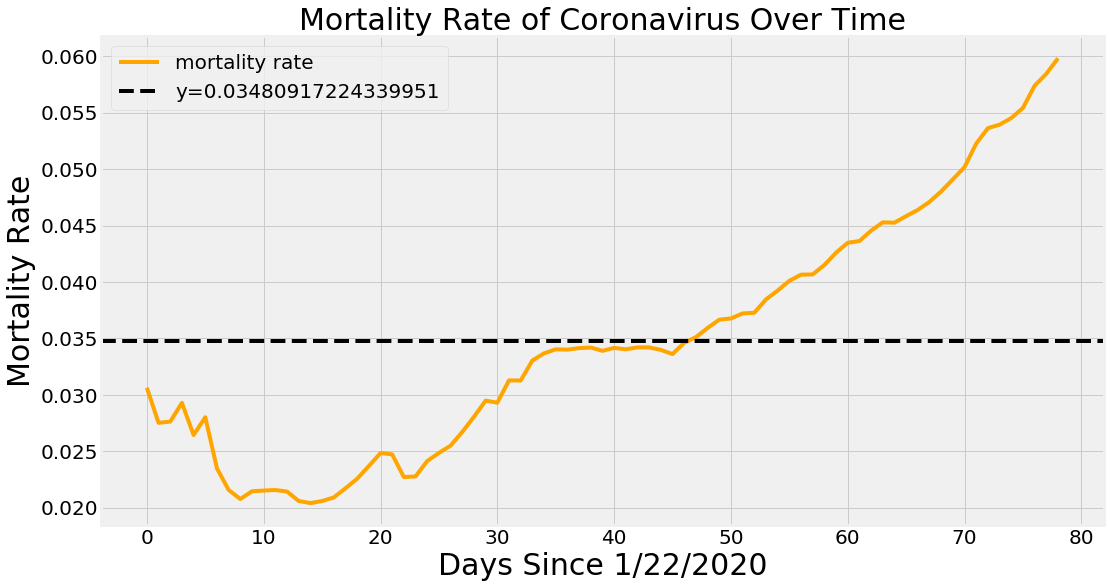

In [168]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

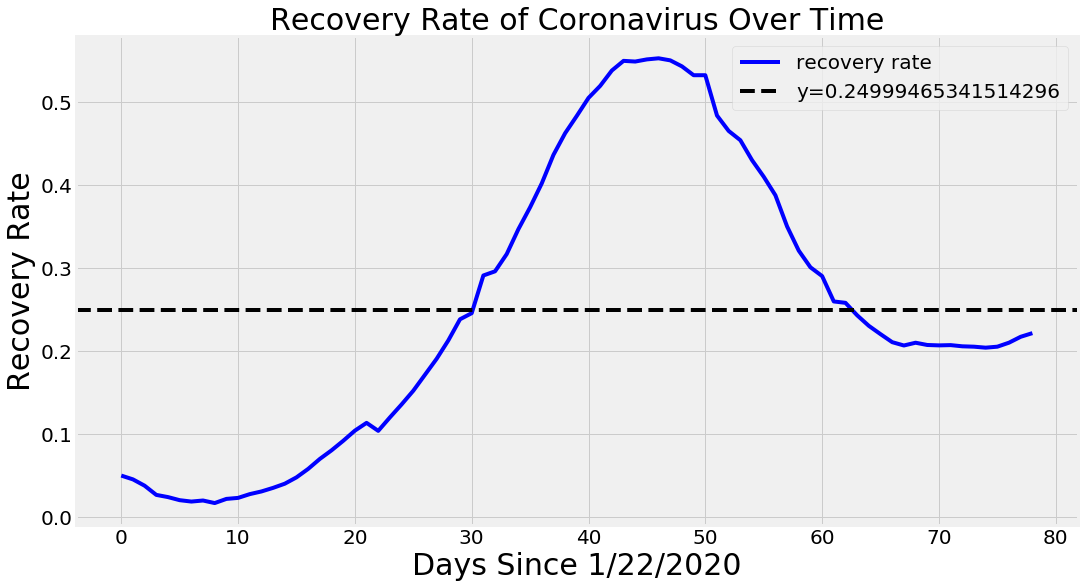

In [169]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Graphing deaths against recoveries

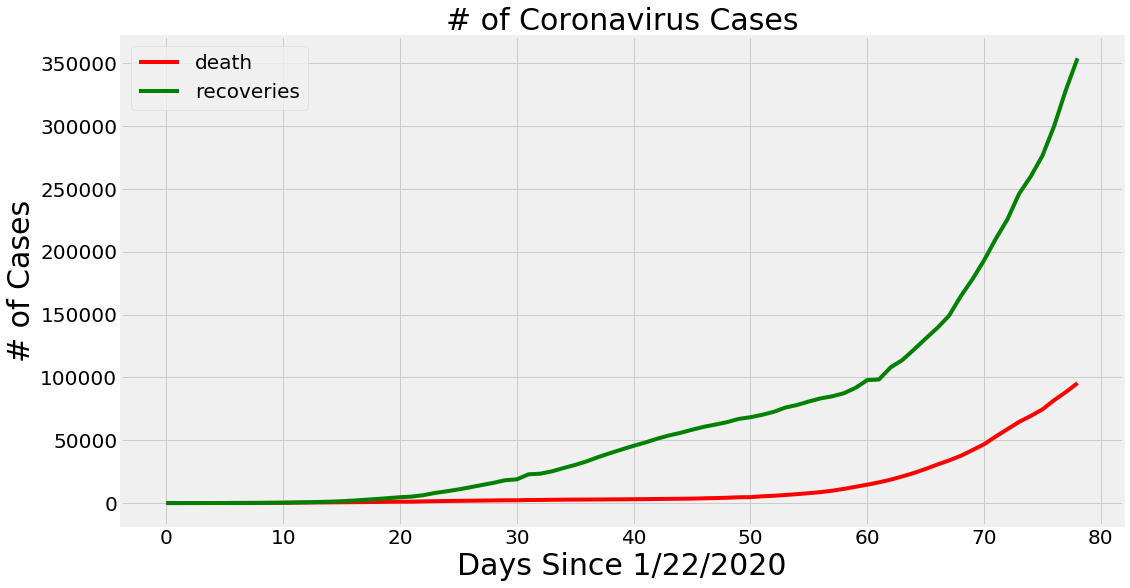

In [170]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Plotting the number of deaths against the number of recoveries

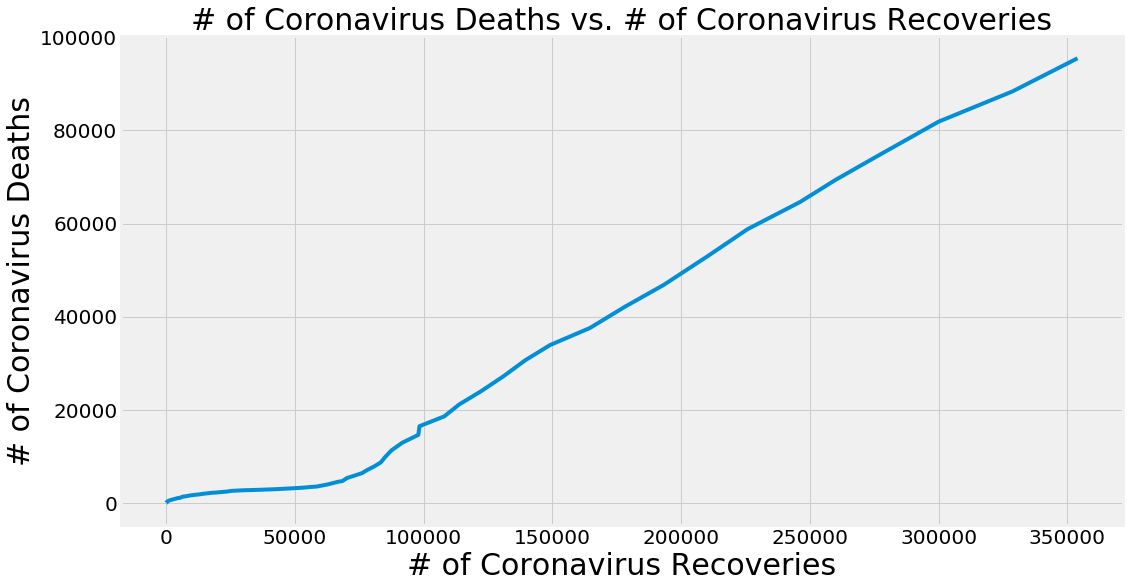

In [171]:
plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Getting information about countries/regions that have confirmed coronavirus cases

In [172]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [173]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [174]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Greens')

In [175]:
unique_provinces =  list(latest_data['Province_State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [176]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [177]:
# number of cases per province/state/city
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})
# number of cases per country/region

province_df.style.background_gradient(cmap='Greens')

In [178]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

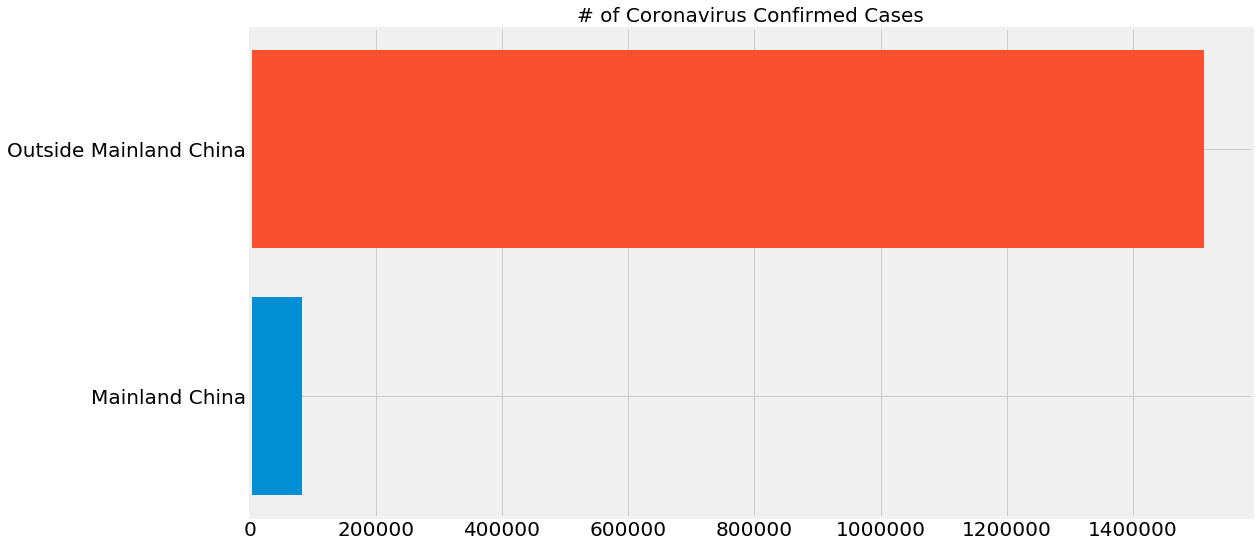

In [179]:
china_confirmed = latest_data[latest_data['Country_Region']=='China']['Confirmed'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [180]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 1512467 cases:
Mainland China: 82883 cases
Total: 1595350 cases


In [181]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

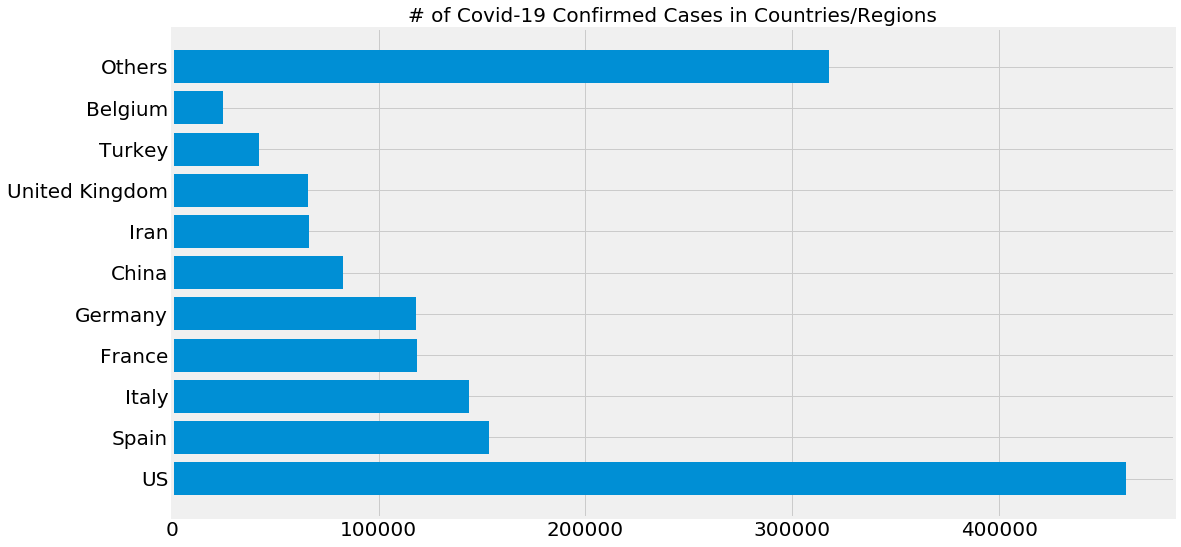

In [182]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

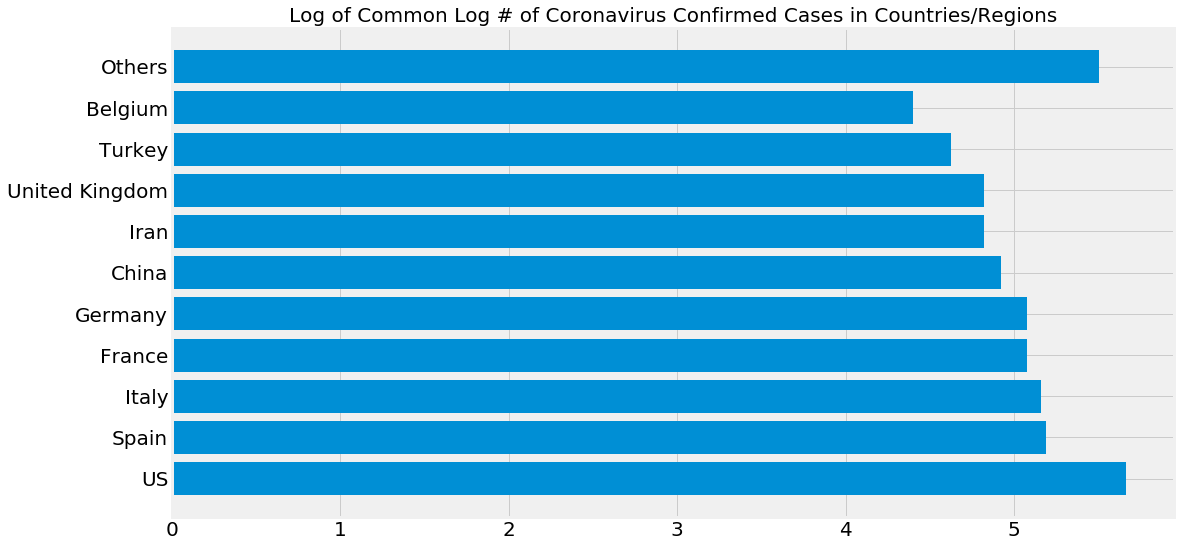

In [183]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [184]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

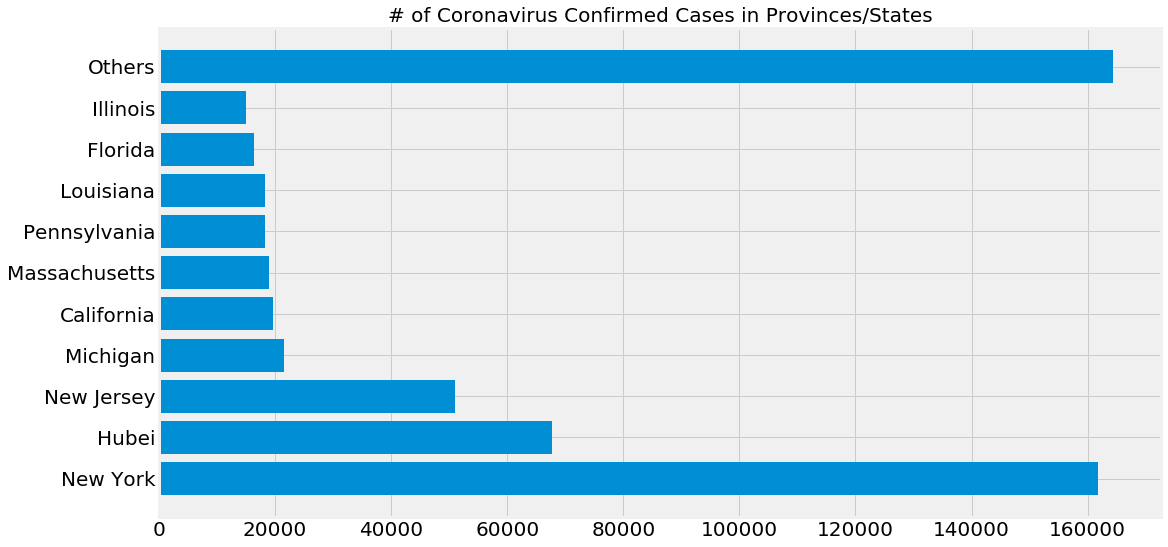

In [185]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

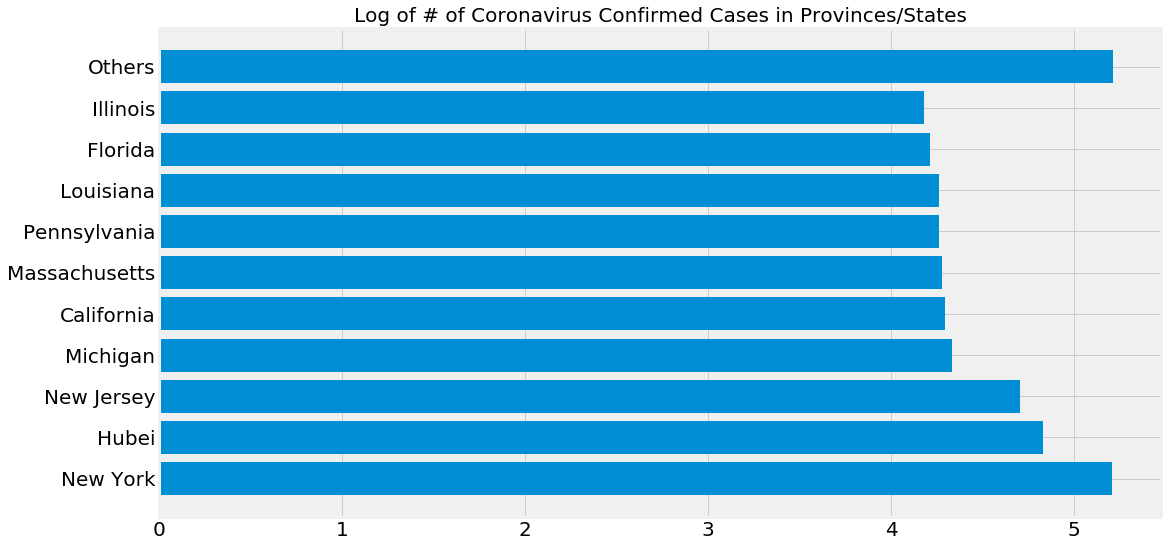

In [186]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

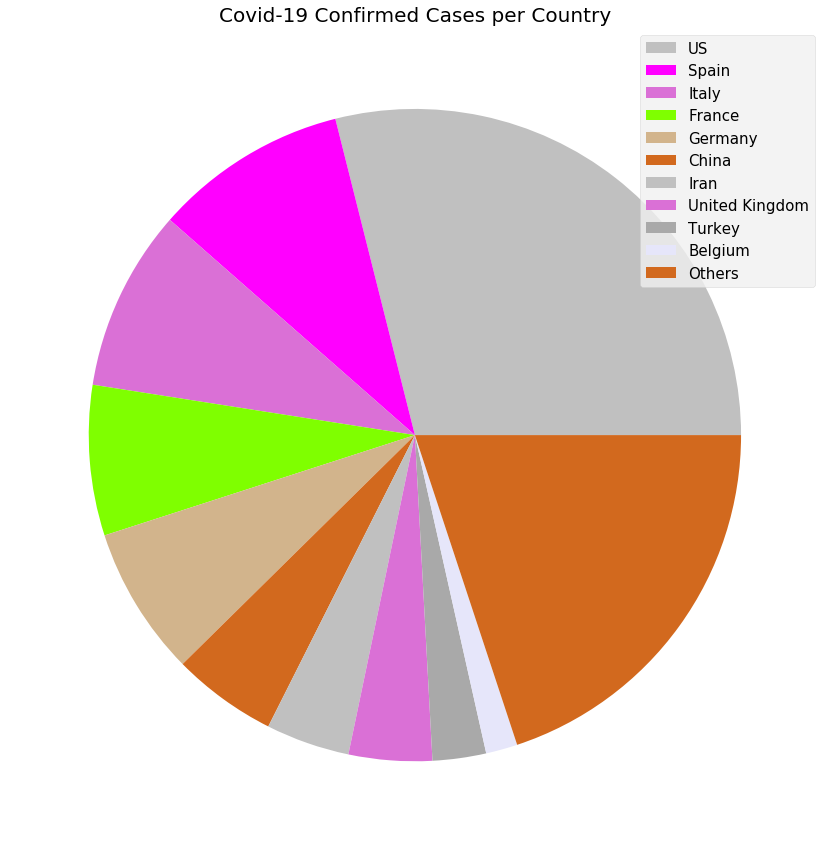

In [187]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()

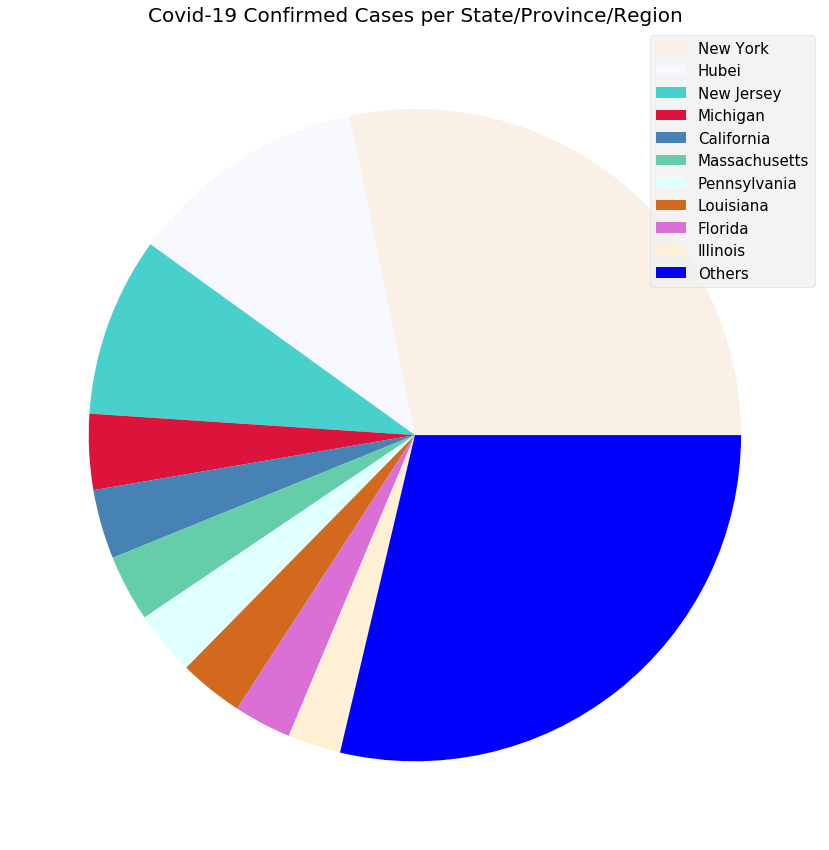

In [188]:
c = random.sample(list(mcolors.CSS4_COLORS.values()),k = len(visual_confirmed_cases2))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per State/Province/Region', size=20)
plt.pie(visual_confirmed_cases2, colors=c)
plt.legend(visual_unique_provinces, loc='best', fontsize=15)
plt.show()

In [189]:
# looking at US States
us_regions = list(latest_data[latest_data['Country_Region']=='US']['Province_State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)
    
# only show the top 10 states
us_regions = [k for k, v in sorted(zip(us_regions, us_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(us_regions)):
    us_confirmed_cases[i] = latest_data[latest_data['Province_State']==us_regions[i]]['Confirmed'].sum()  

us_regions_10 = us_regions[:10]
us_regions_10.append('Others')
us_confirmed_cases_10 = us_confirmed_cases[:10]
us_confirmed_cases_10.append(np.sum(us_confirmed_cases[10:]))

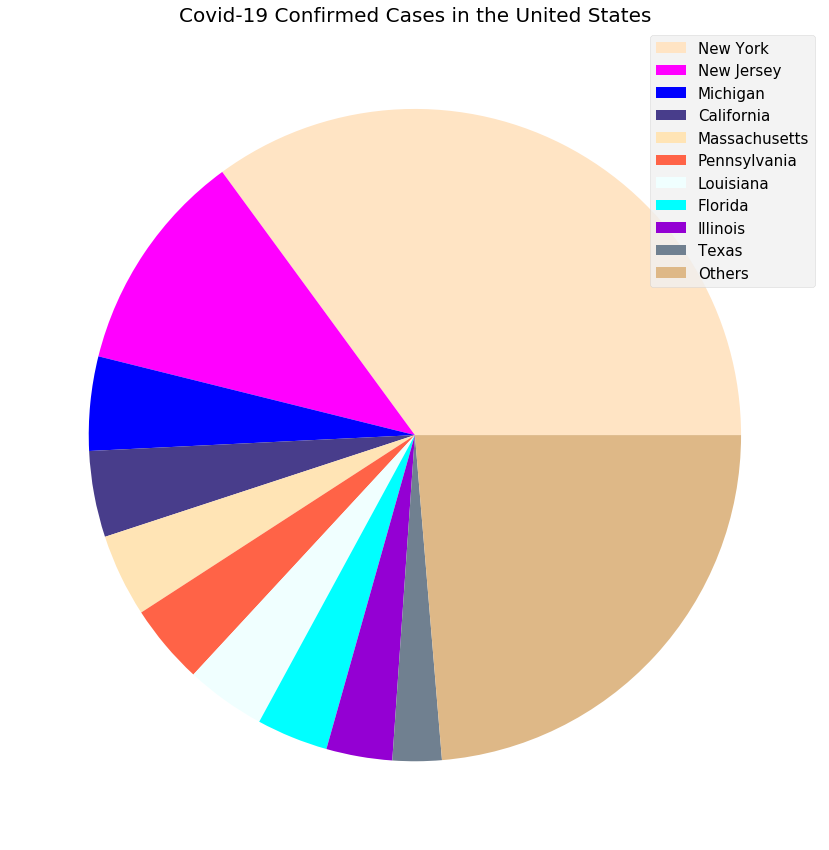

In [190]:
c = random.sample(list(mcolors.CSS4_COLORS.values()),k = len(us_confirmed_cases))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the United States',  size=20)
plt.pie(us_confirmed_cases_10, colors=c)
plt.legend(us_regions_10, loc='best', fontsize=15)
plt.show()

In [191]:
# looking at Chinese provinces
china_regions = list(latest_data[latest_data['Country_Region']=='China']['Province_State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)
    
china_regions = [k for k, v in sorted(zip(china_regions, china_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(china_regions)):
    china_confirmed_cases[i] = latest_data[latest_data['Province_State']==china_regions[i]]['Confirmed'].sum()  

china_regions_10 = china_regions[:10]
china_regions_10.append('Others')
china_confirmed_cases_10 = china_confirmed_cases[:10]
china_confirmed_cases_10.append(np.sum(china_confirmed_cases[10:]))

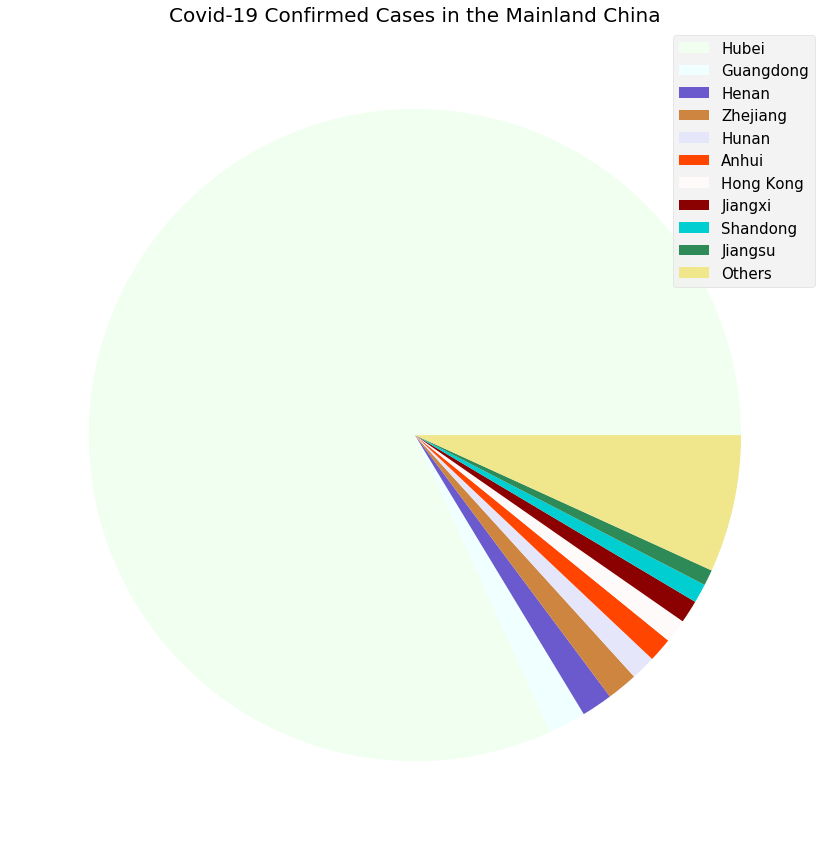

In [192]:
c = random.sample(list(mcolors.CSS4_COLORS.values()),k = len(china_confirmed_cases))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the Mainland China', size=20)
plt.pie(china_confirmed_cases_10, colors=c)
plt.legend(china_regions_10, loc='best', fontsize=15)
plt.show()